In [1]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./00_setup.py").load_module()

## Neural Network With Numeric NAICS "Embeddings"
Use a dense layer to encode the numeric NAICS

*This script takes about 1 hour on my MacBook Air*

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [3]:
from pathlib import Path
import importlib, pickle
from sklearn import model_selection

In [4]:
import pandas as pd
import os
import re

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
from tensorflow.keras.layers import Dense, Dropout, Input, Embedding, Concatenate, Reshape
import tensorflow.keras.metrics as km

In [6]:
from sba_gnn.sba_gnn import sg_plot 

## Input Data

In [7]:
business_data = pd.read_parquet(Path(setup.temp_path).joinpath('10_DATA_combined_scaled_all.parquet'))

In [8]:
# Previously rescaled NAICS data, sorted
X_naics = pd.read_parquet(Path(setup.temp_path).joinpath('13_NAICS_recode.parquet')) 

In [9]:
X_naics_train = X_naics[X_naics['dset'] == 'train'][['NAICS_rescale']]
X_naics_val = X_naics[X_naics['dset'] == 'val'][['NAICS_rescale']]

In [10]:
with open(Path(setup.temp_path).joinpath('10_DATA_features.pkl'), 'rb') as fin:
    imputer_features = pickle.load(fin)

In [11]:
numeric_features = [f for f in imputer_features if f != 'NAICS']
print(numeric_features)

['NoEmp', 'CreateJob', 'LowDoc', 'DisbursementGross', 'new_business', 'urban_flag', 'franchise_flag', 'missingindicator_LowDoc', 'missingindicator_new_business', 'missingindicator_urban_flag']


##### Datasets for train, validation

In [12]:
X = business_data[['dset', 'LoanNr_ChkDgt'] + numeric_features].set_index('LoanNr_ChkDgt').sort_index()

In [13]:
X_train = X[X['dset'] == 'train'].drop(columns='dset')
y_train = business_data[business_data['dset'] == 'train'].set_index('LoanNr_ChkDgt').sort_index()['target']
print(f'training X: {X_train.shape}, y:{y_train.shape}')

training X: (425594, 10), y:(425594,)


In [14]:
X_val = X[X['dset'] == 'val'].drop(columns='dset')
y_val = business_data[business_data['dset'] == 'val'].set_index('LoanNr_ChkDgt').sort_index()['target']
print(f'val X: {X_val.shape}, y:{y_val.shape}')

val X: (126041, 10), y:(126041,)


In [15]:
base_thresh = y_train.mean()
print(base_thresh)

0.20307382152943884


## Function to create model

In [16]:
def create_model(n_feat = len(numeric_features), 
                 naics_emd_dim = setup.nn_naics_embed_size,
                 hidden_size = setup.nn_layer_sizes,
                 activation='tanh', lr=setup.nn_learning_rate,
                 opt_func = setup.nn_optimizer, dropout = setup.nn_dropout,
                embed_layer_name = 'naics_reshape'):
    
    n_layers = len(hidden_size)
    
    features_in = Input(shape=(n_feat,))
    
    # Add a layer for encoding the numeric NAICS
    naics_in = Input(shape=(1,))
    embed_layer = Dense(naics_emd_dim,activation=activation,
                  name=embed_layer_name)(naics_in)

    x = Concatenate(axis=-1)([features_in, embed_layer])
    
    for i in range(n_layers):
        x = Dense(hidden_size[i],activation=activation,
                  name=f'layer_{i:02d}')(x)
        x = Dropout(dropout, name=f'dropout_{i:02d}')(x)
    output = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=[features_in, naics_in], outputs=output)
    
    # Compile model
    optimizer = opt_func(learning_rate=lr)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, 
                  metrics=[km.AUC(curve='PR'), km.AUC(curve='ROC')])
    return model

## Create, fit model

In [17]:
this_model = create_model()

2024-01-13 08:01:44.066936: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-01-13 08:01:44.066967: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-01-13 08:01:44.066974: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-01-13 08:01:44.067014: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-13 08:01:44.067031: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [18]:
this_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_1 (InputLayer)        [(None, 10)]                 0         []                            
                                                                                                  
 naics_reshape (Dense)       (None, 16)                   32        ['input_2[0][0]']             
                                                                                                  
 concatenate (Concatenate)   (None, 26)                   0         ['input_1[0][0]',             
                                                                     'naics_reshape[0][0]']   

In [19]:
this_history = this_model.fit([X_train, X_naics_train], y_train,
                              validation_data=([X_val, X_naics_val], y_val),
                              batch_size=setup.nn_batch_size,
                              epochs=setup.nn_epochs)

Epoch 1/20


2024-01-13 08:01:44.876512: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


13300/13300 [==============================] - ETA: 0s - loss: 0.4734 - auc: 0.3032 - auc_1: 0.6716

2024-01-13 08:05:31.736061: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


13300/13300 [==============================] - 268s 20ms/step - loss: 0.4734 - auc: 0.3032 - auc_1: 0.6716 - val_loss: 0.4687 - val_auc: 0.3303 - val_auc_1: 0.6922
Epoch 2/20
13300/13300 [==============================] - 267s 20ms/step - loss: 0.4661 - auc: 0.3222 - auc_1: 0.6876 - val_loss: 0.4696 - val_auc: 0.3383 - val_auc_1: 0.6973
Epoch 3/20
13300/13300 [==============================] - 268s 20ms/step - loss: 0.4648 - auc: 0.3277 - auc_1: 0.6915 - val_loss: 0.4729 - val_auc: 0.3387 - val_auc_1: 0.6983
Epoch 4/20
13300/13300 [==============================] - 5667s 426ms/step - loss: 0.4641 - auc: 0.3297 - auc_1: 0.6932 - val_loss: 0.4666 - val_auc: 0.3411 - val_auc_1: 0.7000
Epoch 5/20
13300/13300 [==============================] - 6716s 505ms/step - loss: 0.4640 - auc: 0.3307 - auc_1: 0.6935 - val_loss: 0.4670 - val_auc: 0.3420 - val_auc_1: 0.7005
Epoch 6/20
13300/13300 [==============================] - 5733s 431ms/step - loss: 0.4637 - auc: 0.3313 - auc_1: 0.6941 - val_loss: 

In [20]:
this_history_df = pd.DataFrame(this_history.history)

In [22]:
# Rename columns
try:
    this_history_df.columns = ['_'.join(c.split('_')[0:-1])  \
                               if re.search(r'_\d+$', c) else c for c in this_history_df.columns]
except:
    pass
try:
    cur_col = list(this_history_df.columns)
    this_history_df.columns = [cur_col[0]] + \
        [f'{cur_col[i]}_roc'  if (cur_col[i] == cur_col[i-1]) and 'auc'in cur_col[i] \
         else cur_col[i] for i in range(1, len(cur_col))]
except:
    pass

In [23]:
this_history_df.columns

Index(['loss', 'auc', 'auc_roc', 'val_loss', 'val_auc', 'val_auc_roc'], dtype='object')

In [24]:
this_history_df.to_csv(Path(setup.temp_path).joinpath('14_REPORT_fit_history.csv'))

<Axes: >

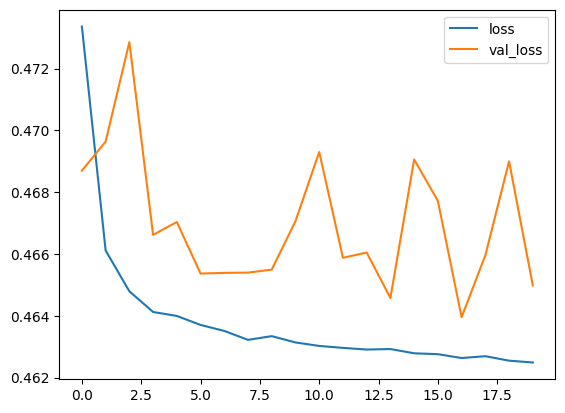

In [25]:
this_history_df[['loss', 'val_loss']].plot()

<Axes: >

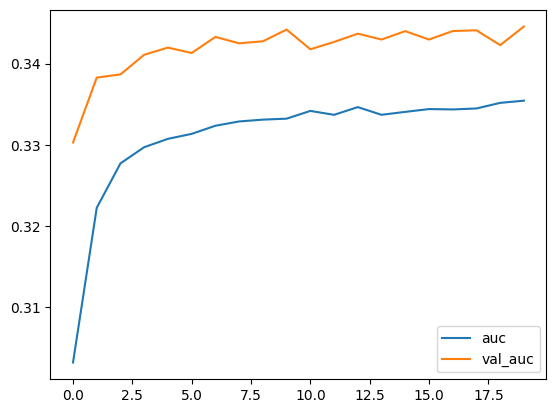

In [26]:
this_history_df[['auc', 'val_auc']].plot()

<Axes: >

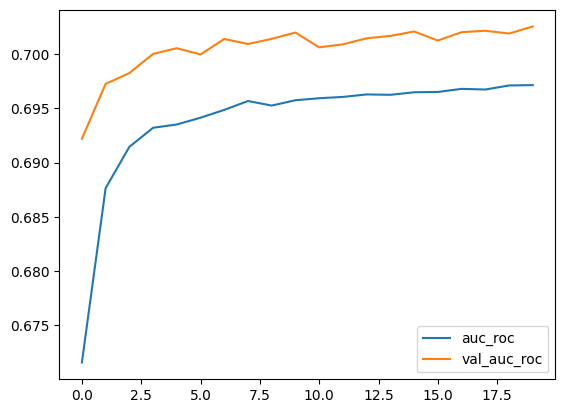

In [27]:
this_history_df[['auc_roc', 'val_auc_roc']].plot()

In [28]:
this_model.save(Path(setup.temp_path).joinpath('14_DATA_model.keras'),save_format='tf')

X_naics## Predictions on all data

In [32]:
all_predictions = this_model.predict([X.drop(columns='dset'), 
                                      X_naics[['NAICS_rescale']]])

   68/21503 [..............................] - ETA: 48s

2024-01-13 22:08:08.809166: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


21503/21503 [==============================] - 56s 3ms/step


In [33]:
all_predictions_df = pd.DataFrame(all_predictions, index=X.index) \
    .set_axis(['predict_prob'], axis=1) \
    .reset_index() \
    .merge(business_data[['target', 'LoanNr_ChkDgt', 'dset', 'dset_naics_holdout', 'NAICS']], 
           on='LoanNr_ChkDgt')

In [34]:
all_predictions_df[['predict_prob', 'target']].corr(method='spearman')

,predict_prob,target
predict_prob,1.000000,0.283577
target,0.283577,1.000000


##### Threshold Tune & Binary Predictions
Using training probability predictions

In [35]:
all_pred_train = all_predictions_df[all_predictions_df['dset'] == 'train']

In [36]:
thresh_tune_data = sg_plot.get_f1_frame(all_pred_train['target'], 
                                        all_pred_train['predict_prob'])

In [37]:
thresh_tune_data.sort_values('f1', ascending=False, inplace=True)
thresh_tune_data.head(3)

,thresh,f1
9,0.18,0.427585
10,0.20,0.427569
8,0.16,0.426278


In [38]:
best_thresh = thresh_tune_data['thresh'].iloc[0]
best_thresh

0.18

##### Append binary predictions to probability predictions

In [39]:
all_predictions_df['predict_bin'] = sg_plot.get_binary_predictions(all_predictions_df['predict_prob'], best_thresh)

In [40]:
all_predictions_df['predict_bin'].value_counts(normalize=True, dropna=False)

predict_bin
1    0.506278
0    0.493722
Name: proportion, dtype: float64

In [41]:
all_predictions_df.to_parquet(Path(setup.temp_path).joinpath('14_DATA_predictions.parquet'))

## Metrics

In [42]:
metrics_dset_df = all_predictions_df.groupby('dset') \
    .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_test_df = all_predictions_df[all_predictions_df['dset'] == 'test'] \
    .groupby(['dset', 'dset_naics_holdout']) \
    .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_df = pd.concat([metrics_dset_df, metrics_test_df])
metrics_df.to_csv(Path(setup.temp_path).joinpath('14_REPORT_metrics.csv'), index=True)
metrics_df

,dset,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score,dset_naics_holdout
0,test,0.596925,0.426674,0.298458,0.748017,0.346962,0.707137,NaN
1,train,0.593295,0.427585,0.299352,0.748007,0.344342,0.702594,NaN
2,val,0.596266,0.432907,0.304288,0.749865,0.344765,0.702651,NaN
0,test,0.593406,0.428606,0.300263,0.748572,0.347996,0.704024,0.0
1,test,0.607815,0.420385,0.292621,0.746182,0.343909,0.716418,1.0


## Embeddings
Get the NAICS embeddings for all codes

In [43]:
embed_layer_name = 'naics_reshape'

In [44]:
unique_naics_x = business_data.drop_duplicates('NAICS_orig') \
    [['LoanNr_ChkDgt'] + numeric_features].set_index('LoanNr_ChkDgt').sort_index()

In [47]:
unique_naics_x_naics = business_data.drop_duplicates('NAICS_orig')[['LoanNr_ChkDgt']] \
    .merge(X_naics.reset_index(), on='LoanNr_ChkDgt') \
    .set_index('LoanNr_ChkDgt').sort_index()

In [48]:
embed_model = Model(inputs=this_model.inputs, outputs=this_model.get_layer(embed_layer_name).output) 

In [49]:
embed_out = embed_model.predict([unique_naics_x, unique_naics_x_naics[['NAICS_rescale']]])

41/41 [==============================] - 0s 1ms/step


2024-01-13 22:14:43.357647: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [50]:
embed_out.shape

(1311, 16)

In [51]:
embed_df = pd.DataFrame(embed_out, index=unique_naics_x.index) 
embed_df.columns = [f'emb_{i:03d}' for i in range(len(embed_df.columns))]
embed_df.reset_index(inplace=True)

In [54]:
embed_df = pd.DataFrame(embed_out, index=unique_naics_x.index)  
embed_df.columns = [f'emb_{i:03d}' for i in range(len(embed_df.columns))]
embed_df = embed_df.reset_index() \
    .merge(unique_naics_x_naics.reset_index(), how='left', on='LoanNr_ChkDgt')

In [55]:
embed_df.head(3)

,LoanNr_ChkDgt,emb_000,emb_001,emb_002,emb_003,emb_004,emb_005,emb_006,emb_007,emb_008,emb_009,emb_010,emb_011,emb_012,emb_013,emb_014,emb_015,dset,NAICS_orig,NAICS_rescale
0,1000014003,-0.003380,0.071330,0.036805,-0.016193,0.006007,0.066684,-0.016118,-0.003553,-0.028936,-0.011909,0.000979,0.039005,-0.026184,0.005236,-0.067212,0.025411,train,451120,-0.219732
1,1000034009,0.041547,-0.177184,-0.040780,-0.042443,0.036241,-0.215743,-0.021489,-0.005150,-0.052652,0.030547,-0.005757,0.048616,0.063680,0.018306,0.091195,-0.023602,train,621210,0.158246
2,1000094005,0.091502,-0.429096,-0.126787,-0.071682,0.069916,-0.491834,-0.027485,-0.006932,-0.079061,0.077812,-0.013276,0.059337,0.162744,0.032891,0.262423,-0.078180,train,811118,0.580264


In [56]:
embed_df.to_parquet(Path(setup.temp_path).joinpath('14_DATA_embeddings.parquet'))